## MLP Autoencoder

* Encoder: Network that extracts meaningful feature from input data.  
* Decoder: Networkd that creates results from the feature  
* Latent feature: Compacted input feature generated by the encoder

* DeconvNet
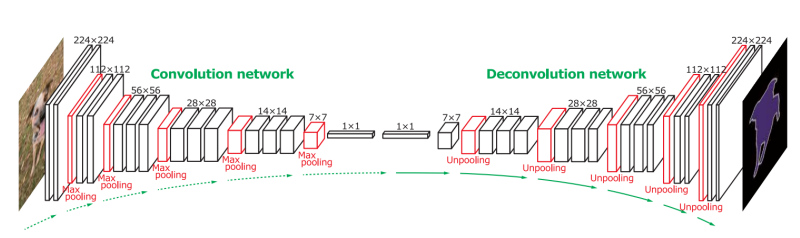  
(Noh, Hyeonwoo, Seunghoon Hong, and Bohyung Han. "Learning deconvolution network for semantic segmentation." ICCV. 2015)  
* U-Net  
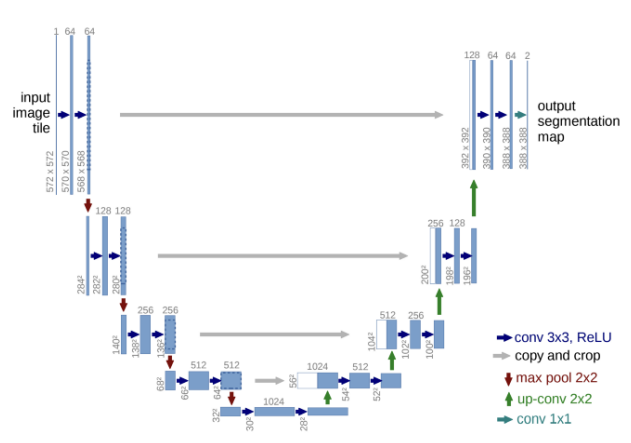  
(RonneBerger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.)

In [2]:
import os
import time
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Data load

In [4]:
mnist_train = datasets.MNIST(
    root="mnist", 
    train=True, 
    download=True, 
    transform=transforms.ToTensor()
)
mnist_test = datasets.MNIST(
    root="mnist", 
    train=False, 
    download=True, 
    transform=transforms.ToTensor()
)

### Train/Valid split

In [5]:
# MNIST DataLoader 생성
random_seed = 0
torch.manual_seed(random_seed)

# Train:Valid = 9:1
val_size = int(len(mnist_train) * 0.1)
train_size = len(mnist_train) - val_size

mnist_train, mnist_valid = random_split(mnist_train, [train_size, val_size])
print(len(mnist_train), len(mnist_valid))

54000 6000


In [6]:
mnist_dataset = [mnist_train, mnist_valid, mnist_test]

mnist_train_loader = DataLoader(dataset=mnist_train, batch_size=64, shuffle=True, drop_last=True)
mnist_valid_loader = DataLoader(dataset=mnist_valid, batch_size=64, shuffle=False, drop_last=True)   
mnist_test_loader = DataLoader(dataset=mnist_test, batch_size=64, shuffle=False, drop_last=True)

### Build an MLP autoencoder model.

In [7]:
class MLP_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 28 * 28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        latent_x = self.encoder(x)
        y = self.decoder(latent_x)
        y = y.view(-1,1, 28, 28)
        return y

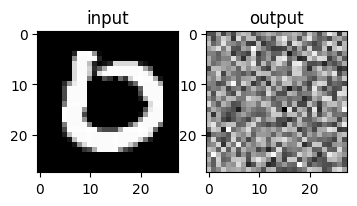

In [8]:
sample_x = mnist_valid[0][0].unsqueeze(dim=0)
mlp_ae = MLP_Autoencoder()
y = mlp_ae(sample_x)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(sample_x.squeeze(), cmap='gray')
ax.title.set_text("input")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(y.detach().squeeze(), cmap='gray')
ax.title.set_text("output")

### Train the model

In [9]:
class Autoencoder_Trainer(nn.Module):
    def __init__(self, model, dataset, opt="adam", lr=0.001, has_scheduler=False, device="cpu"):
        """
        Args:
        model: A classification model that you want to use
        n_class: Number of class 
        opt: Optimizer
        lr: Learning rate
        has_scheduler: True if you want to use the learning rate scheduler
        device: Device that you are using for the training(cpu/cuda).
        """
        super().__init__()

        self.model = model                            
        self.loss = nn.MSELoss()

        self._get_optimizer(opt=opt.lower(), lr=lr)
        self.has_scheduler = has_scheduler
        if self.has_scheduler:
            self._get_scheduler()

        self.device = device
        self.train_data = dataset[0]
        self.valid_data = dataset[1]
        self.test_data = dataset[2]

    def _get_optimizer(self, opt, lr=0.001):
        """
        Args:
        opt: Optimizer
        lr: Learning rate
        """
        if opt == "sgd":
            self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
        elif opt == "adam":
            self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
        else:
            raise ValueError(f"optimizer {opt} is not supproted")

    def _get_scheduler(self):
        # self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=self.optimizer, lr_lambda=lambda epoch: 0.95**epoch)

    def train(self, train_loader, valid_loader, max_epochs=10, disp_epoch=5, visualize=False):
        """
        A function to train the model.
        Args:
        train_loader: Train dataset loader
        valid_loader: Validation dataset loader
        max_epochs: Number of epochs
        disp_epochs: Number of epoch frequency to display training logs
        visualize: True if you want to plot the image of the result
        """
        print("===== Train Starts. =====")
        start_time = time.time()   
        history = {"train_loss": [], "valid_loss": []}
        for e in range(max_epochs):
            train_loss = self._train_epoch(train_loader)
            valid_loss = self._valid_epoch(valid_loader)

            history["train_loss"].append(train_loss)
            history["valid_loss"].append(valid_loss)

            if self.has_scheduler:
                self.scheduler.step()

            if e % disp_epoch == 0: 
                print(f"Epoch: {e}, train loss: {train_loss:>6f}, valid loss: {valid_loss:>6f}, time: {time.time()-start_time:>3f}")
                if visualize: 
                    self.vis_train_val() 
                start_time = time.time()   

        self.plot_history(history)

    def _train_epoch(self, train_loader):
        """
        A function that trains the model by each epoch
        Args:
        train_loader: Train dataset loader
        Returns: Average loss and accuracy
        """
        epoch_loss = 0
        self.model.train()
        for (x, y) in train_loader:

            x = x.to(self.device)

            x_hat = self.model(x) # input X restored by the model 
            loss = self.loss(x_hat, x)       

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            epoch_loss += loss.to("cpu").item()    

        epoch_loss /= len(train_loader)  

        return epoch_loss
  
    def _valid_epoch(self, valid_loader):
        """
        A function that evaluate the current model with validation dataset.
        Args:
        valid_loader: Validation dataset loader
        Returns: Average loss and accuracy
        """
        epoch_loss = 0
        self.model.eval()
        with torch.no_grad():
            for (x, y) in valid_loader:
                x = x.to(self.device)

                x_hat = self.model(x)
                loss = self.loss(x_hat, x)

                epoch_loss += loss.to("cpu").item()

        epoch_loss /= len(valid_loader)

        return epoch_loss

    def plot_history(self, history):
        """
        A  function that plots the history of the model.
        Args:
        history: dictionary with keys {"train_loss", "train_acc", "valid_loss", "valid_acc" }
        """
        fig = plt.figure(figsize=(10, 10))

        plt.plot(history["train_loss"], color="red", label="train loss")
        plt.plot(history["valid_loss"], color="blue", label="valid loss")
        plt.title("Loss")
        plt.legend()

    def test(self, test_loader):
        """
        A function to evaluate the model with test dataset.
        Args:
        test_loader: Test dataset loader
        Returns: Average loss and accuracy
        """
        print("===== Test Starts. =====")
        start_time = time.time()
        epoch_loss = 0
        self.model.eval()
        with torch.no_grad():
            for (x, y) in test_loader:
                x = x.to(self.device)

                x_hat = self.model(x)
                loss = self.loss(x_hat, x)

                epoch_loss += loss.to("cpu").item()

        epoch_loss /= len(test_loader)

        print(f"Test loss: {epoch_loss:>6f}, time: {time.time()-start_time:>3f}")
        self.vis_test()
    
    def vis_train_val(self):
        """
        A function to visualize the training and validation results.
        """
        fig = plt.figure(figsize=(4,4))
        for i in range(4):
            img = self.train_data[i][0]
            ax = fig.add_subplot(4, 4, i*4+1)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_train")

            img = self.model(self.train_data[i][0].unsqueeze(dim=0).to(device)).to("cpu").detach()
            ax = fig.add_subplot(4, 4, i*4+2)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_hat_train")

            img = self.valid_data[i][0]
            ax = fig.add_subplot(4, 4, i*4+3)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_valid")

            img = self.model(self.valid_data[i][0].unsqueeze(dim=0).to(device)).to("cpu").detach()
            ax = fig.add_subplot(4, 4, i*4+4)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_hat_valid")
        
    def vis_test(self):
        """
        A function to visualize the test result.
        """
        fig = plt.figure(figsize=(4,4))
        for i in range(4):
            img = self.test_data[i][0]
            ax = fig.add_subplot(4, 2, i*2+1)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_test")

            img = self.model(self.test_data[i][0].unsqueeze(dim=0).to(device)).to("cpu").detach()
            ax = fig.add_subplot(4, 2, i*2+2)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_hat_test")

===== Train Starts. =====
Epoch: 0, train loss: 0.051325, valid loss: 0.030722, time: 18.823686
Epoch: 1, train loss: 0.025025, valid loss: 0.021766, time: 15.905487
Epoch: 2, train loss: 0.019716, valid loss: 0.018397, time: 16.723299
Epoch: 3, train loss: 0.017420, valid loss: 0.016658, time: 15.157482
Epoch: 4, train loss: 0.016048, valid loss: 0.015535, time: 14.191073
Epoch: 5, train loss: 0.015003, valid loss: 0.014618, time: 15.269193
Epoch: 6, train loss: 0.014161, valid loss: 0.013833, time: 17.325986
Epoch: 7, train loss: 0.013463, valid loss: 0.013315, time: 23.631450
Epoch: 8, train loss: 0.012934, valid loss: 0.012846, time: 15.344984
Epoch: 9, train loss: 0.012608, valid loss: 0.012863, time: 18.902588
Training time : 176.557106
===== Test Starts. =====
Test loss: 0.012376, time: 1.672530


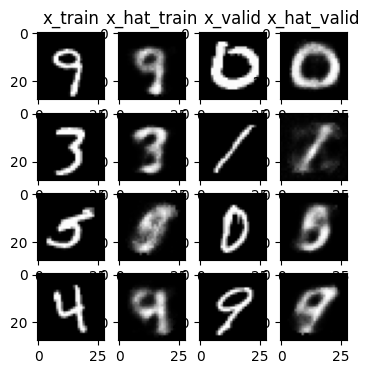

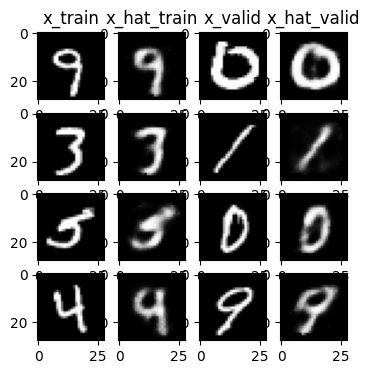

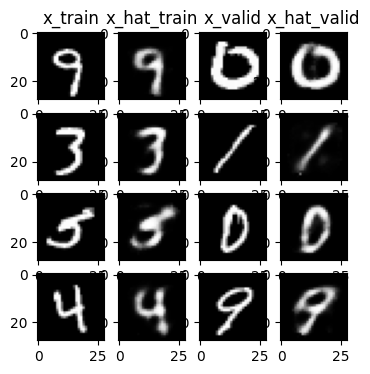

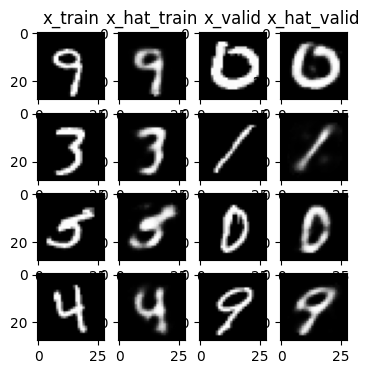

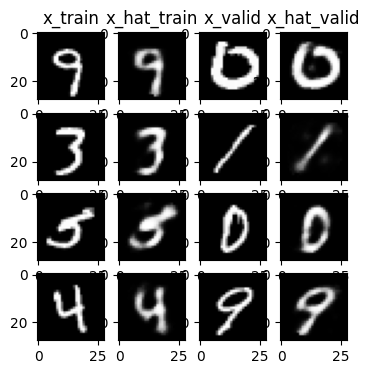

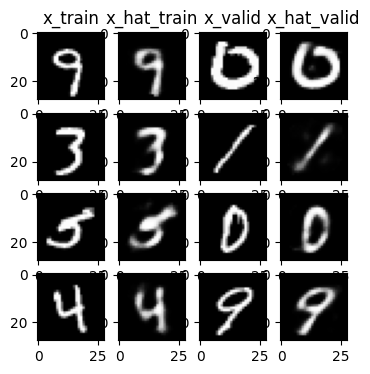

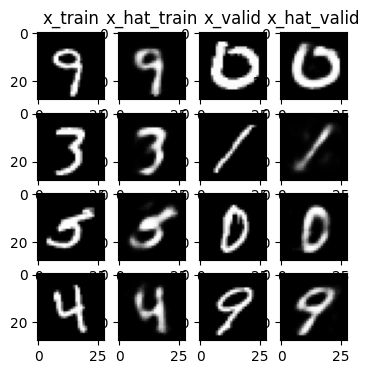

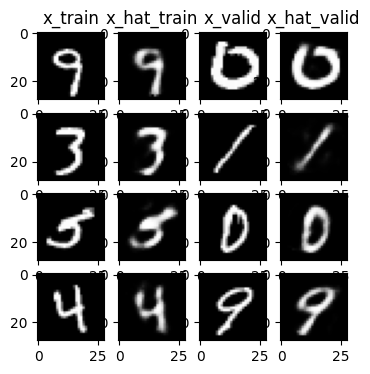

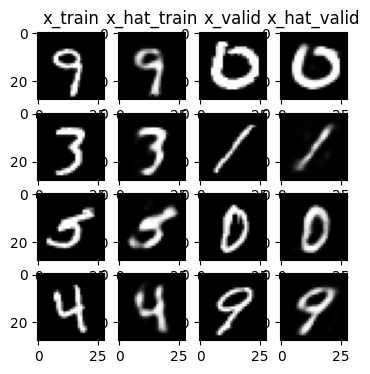

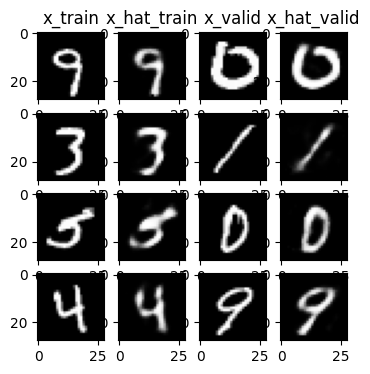

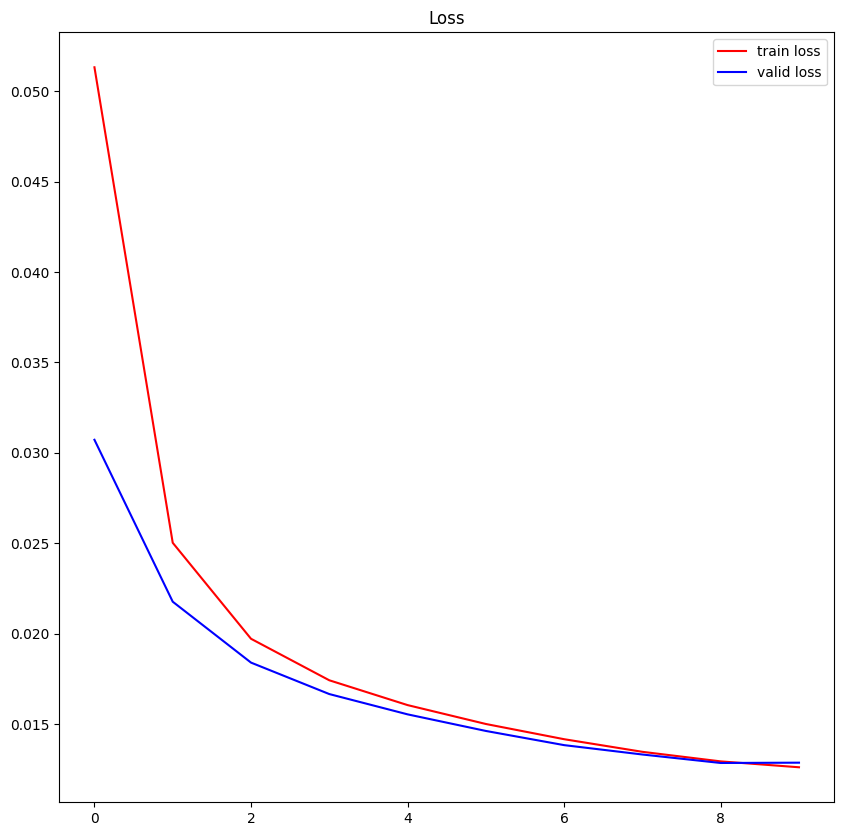

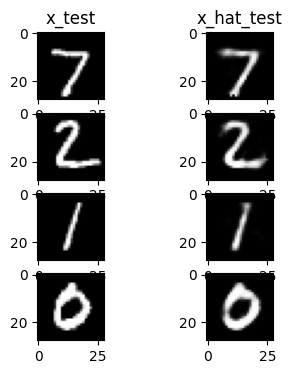

In [10]:
device = "cpu"
mlp_ae = MLP_Autoencoder()
trainer = Autoencoder_Trainer(model=mlp_ae, 
                              dataset=mnist_dataset,
                              opt="adam", 
                              lr=0.001, 
                              has_scheduler=False, 
                              device=device).to(device)
start_time = time.time()

trainer.train(mnist_train_loader, 
              mnist_valid_loader, 
              max_epochs=10, 
              disp_epoch=1, 
              visualize=True)

print(f"Training time : {time.time()-start_time:>3f}")
trainer.test(mnist_test_loader)